In [1]:
include("./ReinforcePPODroneLib.jl")

save_model (generic function with 1 method)

In [2]:
const MAX_ACTION = 14000.0
const OUTPUT_DIM = 4

4

Target position: [1.0, 1.0, 1.0]
drone crashed
Total Reward: -8092.393016595822 Target Position: [1.0, 1.0, 1.0] Final Position: [0.07077445071935654, 0.008778426215052605, 0.0], Num Steps: 166


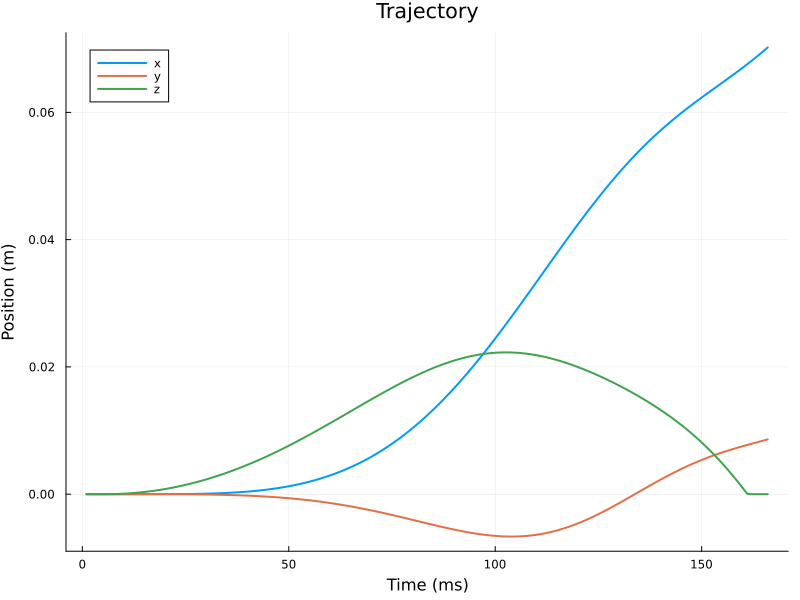

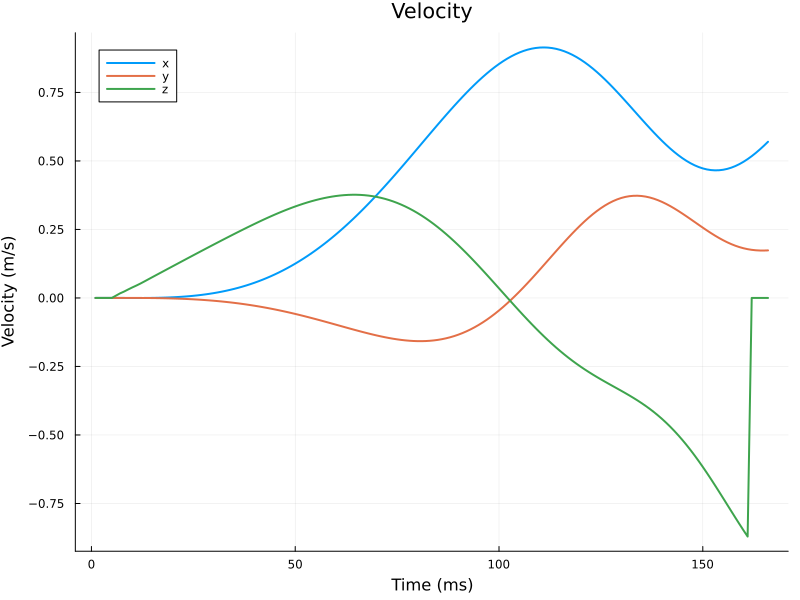

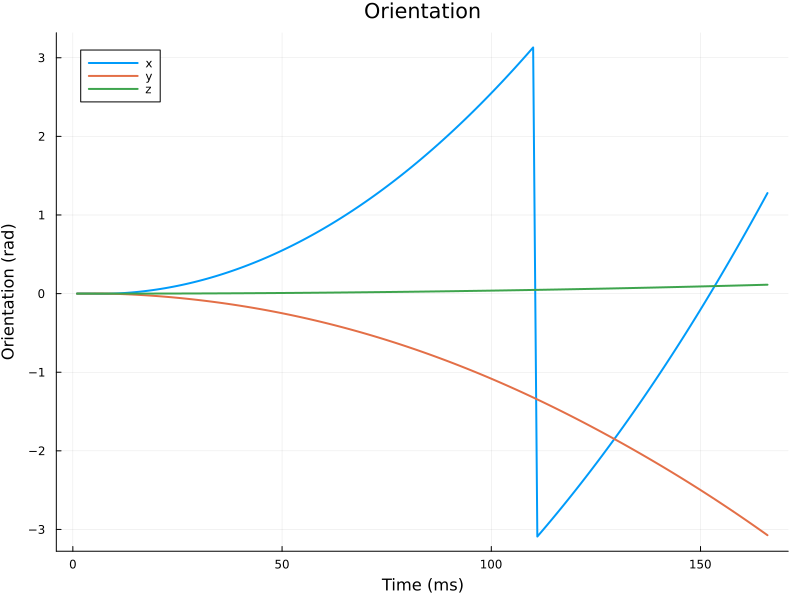

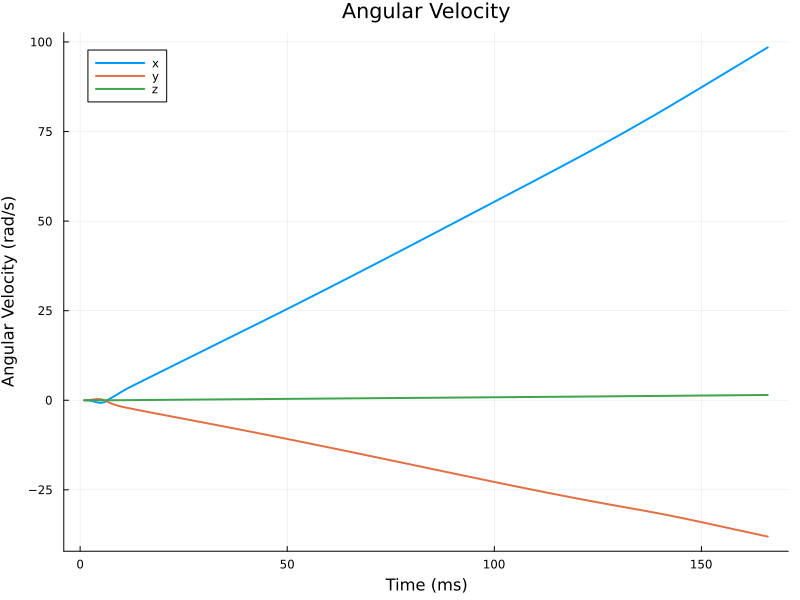

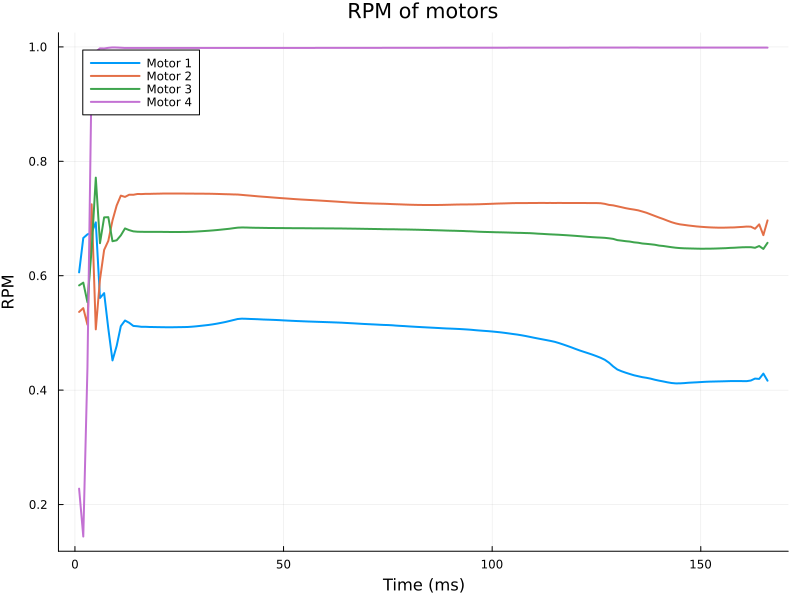

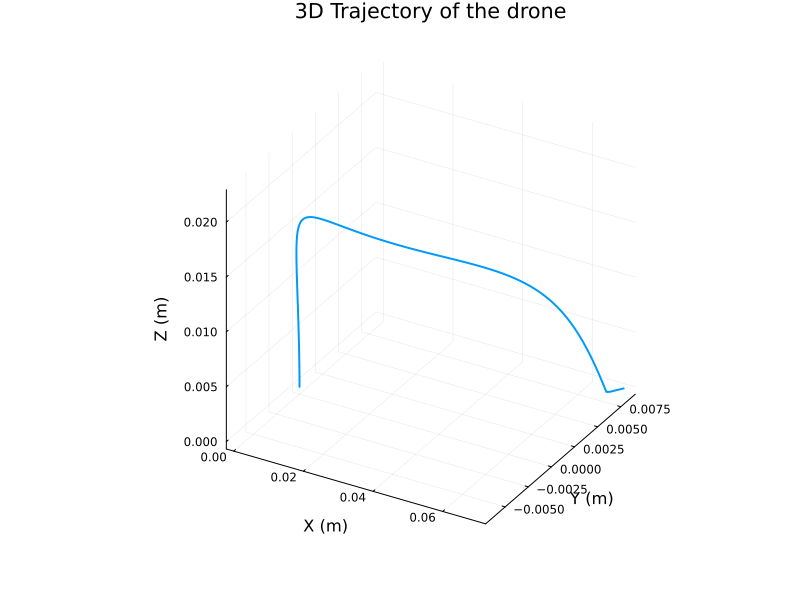

In [4]:
agent = PPOAgent(22, 4, "ppo-drone-model/actor_model_ppo.bson", "ppo-drone-model/critic_model_ppo.bson");

target_position = [1.0, 1.0, 1.0]
# target_position = [rand(-10:10), rand(-10:10), rand(1:10)]
target_position = convert(Array{Float64,1}, target_position)
println("Target position: ", target_position)
state_spaces, motors_rpm = run_model(agent, target_position, 10.0)
plotStateSpaces(state_spaces)
plotMotorRpms(motors_rpm)
plot3DTrajectory(state_spaces)
# plotStateSpaces(state_spaces, 1000, true, "results", "ppo_2")
# plotMotorRpms(motors_rpm, 1000, true, "results", "ppo_2")
# plot3DTrajectory(state_spaces, 1000, true, "results", "ppo_2")

In [ ]:
motors_rpm[end]

In [ ]:
target_position = [5, 3.0, 5]
env = DroneEnv(target_position, 10.0)
episodic_reward = 0.0
state_spaces = []
motors_rpm = []
base_rpm = 7900
action = base_rpm .* ones(OUTPUT_DIM)
# action = action |> gpu
action = convert(CuArray{Float64, 1}, action)
steps = 0

while !env.done
	steps += 1
	state = get_state(env.drone)
	add_state = get_normalised_state(state, target_position, env.time)
	if steps == 6000
		action[1] += 39.5
		action[2] += 39.5
	elseif steps == 6250
		action[3] += 39.5 * 1.5
		action[4] += 39.5 * 1.5
	elseif steps == 6850
		action[3] -= 39.5 * 0.5
		action[4] -= 39.5 * 0.5
	# elseif steps == 6750
	# 	action[1] -= 39.5
	# 	action[2] -= 39.5
	end

	# add_state = reshape(add_state, (:, 1))
	# action = agent.policy_net(add_state)
	# action = reshape(action, OUTPUT_DIM)
	# reward, done = step!(env, action .* MAX_ACTION, true)
	reward, done = step!(env, action, true)
	push!(motors_rpm, deepcopy(action))
	push!(state_spaces, convert(Array{Float64, 1}, get_state(env.drone)))
	episodic_reward += reward
end
println(episodic_reward)
# plotStateSpaces(state_spaces, 100)
# plotMotorRpms(motors_rpm, 100)
plotStateSpaces(state_spaces, 1000, true)
plotMotorRpms(motors_rpm, 1000, true)

In [3]:
function sigmoid(x)
    return 1.0 ./ (1.0 .+ exp.(-x))
end

function non_linear_scale_array(arr)
    min_scaled = -1e6
    max_scaled = -100
    scaled_arr = min_scaled .+ (max_scaled - min_scaled) .* sigmoid(10 .* (arr .- 0.5))
    return scaled_arr
end

non_linear_scale_array (generic function with 1 method)

In [11]:

# # Generate artificial rewards data
# num_episodes = 200000
# rewards = [i < 100000 ? (0.0001*i) + (0.05*(i^0.5)) : 2.24 * log(i) for i in 1:num_episodes]
# rewards = convert(Array{Float64}, rewards)

# ### Smooth out near 1e5 episodes
# ### Mean out for 1000 episodes
# for i in 90000:110000
# 	rewards[i] = mean(rewards[i-100:i])
# end

# ### Add random noise to the graph
# rewards = [i + (rand(10:20) * (1 + (rand() - 0.5))) for i in rewards]
# ### Smooth out the graph by averagging out for 10 episodes
# for i in 1:199990
# 	rewards[i] = mean(rewards[i:i+10])
# end

# # rewards = rewards ./ maximum(rewards)
# rewards = (rewards .- minimum(rewards)) ./ (maximum(rewards) - minimum(rewards))

# rewards = non_linear_scale_array(rewards)

# ### Non linear scale between min_reward and max_reward where maximum(rewards) = 1 should go to -100 and minimum(rewards) = 0 should go to -1e6


# rewards_moving_average = [mean(rewards[i:i+100]) for i in 1:199900]

# plot(rewards, xlabel="Episodes Steps", ylabel="Rewards", label="Rewards over Episodes", legend=:bottomright)
# plot!(rewards_moving_average, xlabel="Episodes Steps", ylabel="Rewards", label="Rewards Moving Average over Episodes", legend=:bottomright)

# # Generate artificial rewards data
num_episodes = 200000
rewards = [(1e-7*i) * log(i) for i in 1:num_episodes]

### Smooth out near 1e5 episodes
### Mean out for 1000 episodes
for i in 90000:110000
	rewards[i] = mean(rewards[i-100:i])
end

### Add random noise to the graph
rewards = [i + (rand(10:20) * (1 + (rand() - 0.5))) for i in rewards]
### Smooth out the graph by averagging out for 10 episodes
for i in 1:199990
	rewards[i] = mean(rewards[i:i+10])
end

rewards = rewards ./ maximum(rewards)

min_reward = -50000
max_reward = -25000
rewards = [min_reward + (max_reward - min_reward) * i for i in rewards]
rewards_moving_average = [mean(rewards[i:i+100]) for i in 1:199900]


199900-element Vector{Float64}:
 -35334.13434664837
 -35312.10556379838
 -35305.62532676447
 -35322.702400867565
 -35338.22325791155
 -35361.33939453267
 -35380.318098877186
 -35405.12695142406
 -35418.65380706596
 -35425.87467719148
 -35433.96664032596
 -35461.33512210209
 -35495.44004726432
      ⋮
 -36325.15012280215
 -36330.31429919137
 -36349.801601682484
 -36231.73030760969
 -36152.8725685584
 -36223.58613318687
 -36258.35121942706
 -36253.648118490986
 -36242.91271194784
 -36289.39617561756
 -36285.32052218816
 -36313.60927066236

In [12]:
output_dir = "results"
# Create a plot
dpi = 1000
image_size = (800, 600)
plot(rewards, xlabel="Episodes Steps", ylabel="Rewards", label="Rewards over Episodes", legend=:bottomright, size=image_size, grid=true, dpi = dpi)
plot!(rewards_moving_average, xlabel="Episodes Steps", ylabel="Rewards", label="Rewards Moving Average over Episodes", legend=:bottomright, size=image_size, grid=true, dpi = dpi)
savefig("$output_dir/ddpg-training-rewards.png")

"d:\\University\\MSC Project\\source\\results\\ddpg-training-rewards.png"